# Improving Employee Retention 
## Insight data challenge 
## Mihye Choi 

# Executive Summary

## The goal here is to predict when employees are going to quit by understanding the main drivers of employee churn.

### Based on historical data from employees who have left companies, the following actions may help improve employee retention:

1. Salary has a small positive effect on retention. So if budget permits, it would be optimal to pay more.
2. The most likely time for an employee to turnover occurs between 250 days and 500 days, just around 1 year of tenure. There could be a variety of reasons behind this, from pressure of ramping up, to perverse incentive like vesting schedules. It would be worthwhile to dive deeper into this topic.
3. Entry level employees are less likely to turnover. Mid level employees with 5-15 years of experience at significantly more likely. There is likely more opportunity in the job market for these employees so the company need to focus on the mid-levels for retention improvement efforts
4. Customer service agents are both far more likely to turnover and have more in absolutely turnovers. This is a significant drain on company resources and HR must leverage salary or other quality of life tools to improve retention.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
import statsmodels.api as sm
import datetime

## Data Overview and Cleaning:

Below is a sample of the data showing the available features including employee ID, company ID, department, seniority, salary, work start date (join_date), and quit date (if the employee is still working for the company, value in quit_date is missing (NaN).

Inital descriptive statistics and exploratory data analysis showed (1) several data have more than 70 years of seniority and (2) different format in 'date' data. Because (1) data with > 70 year seniority are likely entry errors, and (2) the date is from '2011-01-24' (start-date) to '2015-12-13' (end-date), data ranged beyond (!) and (2) were removed. There were no other obvious outlier values in the other continuous variables.

Additionally I created two new culumns (1) 'turnover' and (2) 'days at company' for the final model creation.

In [2]:
df = pd.read_csv('employee_retention_data.txt', delimiter=',')
df= df.drop(df.columns[[0]], axis=1)
df.sample(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
25485,1003110.0,4,temp_contractor,0,5879.0,2010-07-20,2010-10-18
25601,1007158.0,2,temp_contractor,0,5103.0,2007-04-17,2007-07-16
31689,427983.0,1,customer_service,14,72000.0,2014-08-18,NaN
17523,640866.0,5,sales,16,199000.0,2015-10-19,NaN
17964,291437.0,1,data_science,28,311000.0,2014-09-22,NaN


In [3]:
# Data pre-processing and cleaning 
dept_check = df.dept.value_counts()/len(df) # typo check 
print(dept_check)

df = df[df.seniority < 70] # seniority value check, value over 70 is likely to be an error
df['join_date'] = pd.to_datetime(df.join_date) # to have the consistent date format, print(df.join_date.min())
df['quit_date'] = pd.to_datetime(df.quit_date) # print(df.quit_date.max())
start_date = '2011-01-24'# set the right range 
end_date = '2015-12-13'# set the right range 
mask = (df['join_date'] > start_date) & (df['join_date'] <= end_date)
df = df.loc[mask]
df.sample(10)


temp_contractor     0.288168
customer_service    0.264538
engineer            0.132932
data_science        0.091926
sales               0.091407
marketing           0.091263
design              0.039767
Name: dept, dtype: float64


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
28529,442114.0,3,marketing,23,148000.0,2015-06-15,NaT
16661,862673.0,1,customer_service,8,85000.0,2014-03-03,NaT
16186,924889.0,2,marketing,19,179000.0,2015-02-09,NaT
32468,850065.0,1,engineer,22,270000.0,2015-08-17,NaT
5967,727709.0,1,data_science,23,276000.0,2011-02-07,2014-10-10
4844,235468.0,3,data_science,13,143000.0,2013-07-01,NaT
13585,759411.0,4,customer_service,20,86000.0,2014-04-28,2015-06-12
27320,684521.0,1,customer_service,15,114000.0,2013-10-21,2014-10-31
10,430126.0,2,data_science,3,77000.0,2015-08-03,NaT
8071,675392.0,7,engineer,24,270000.0,2014-09-09,NaT


In [4]:
# make new columns,  (2)  
df['quit'] = df['quit_date'].fillna(0) # make a new column for retention,  turnover (quit =1). 
df.quit[df.quit != 0] = 1
df['quit']= df['quit'].astype(int)

df['quit_date2'] = df['quit_date'].fillna('2015-12-13') # days_at_company for calculating retention days
df['quit_date2']=  pd.to_datetime(df.quit_date2)
df['days_at_company'] = df['quit_date2']-df['join_date']
df['days_at_company'] = df['days_at_company'].dt.days
df

<ipython-input-4-f1ff1496b65b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.quit[df.quit != 0] = 1


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit,quit_date2,days_at_company
1,388804.0,8,design,21,191000.0,2011-05-17,2012-03-16,1,2012-03-16,304
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10,1,2015-04-10,1110
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30,1,2015-01-30,662
5,287530.0,5,marketing,20,180000.0,2014-06-30,NaT,0,2015-12-13,531
6,561043.0,3,customer_service,18,119000.0,2012-07-02,2014-03-28,1,2014-03-28,634
...,...,...,...,...,...,...,...,...,...,...
34695,414232.0,6,design,22,150000.0,2014-09-29,2015-10-30,1,2015-10-30,396
34696,702053.0,2,design,23,192000.0,2015-06-29,NaT,0,2015-12-13,167
34697,998574.0,5,marketing,6,106000.0,2013-09-23,2015-07-31,1,2015-07-31,676
34698,90987.0,3,customer_service,2,24000.0,2011-06-06,2013-07-11,1,2013-07-11,766


# Exploratory Data Analysis (EDA)

         employee_id    company_id     seniority         salary          quit  \
count   24619.000000  24619.000000  24619.000000   24380.000000  24619.000000   
mean   501670.191153      3.427556     14.118526  138160.746514      0.545392   
std    288930.746415      2.700800      8.055201   76045.876338      0.497945   
min        36.000000      1.000000      1.000000   17000.000000      0.000000   
25%    250469.500000      1.000000      7.000000   79000.000000      0.000000   
50%    500786.000000      2.000000     14.000000  123000.000000      1.000000   
75%    753147.000000      5.000000     21.000000  187000.000000      1.000000   
max    999969.000000     12.000000     29.000000  408000.000000      1.000000   

       days_at_company  
count     24619.000000  
mean        573.721435  
std         361.316221  
min           3.000000  
25%         333.000000  
50%         424.000000  
75%         781.000000  
max        1777.000000  


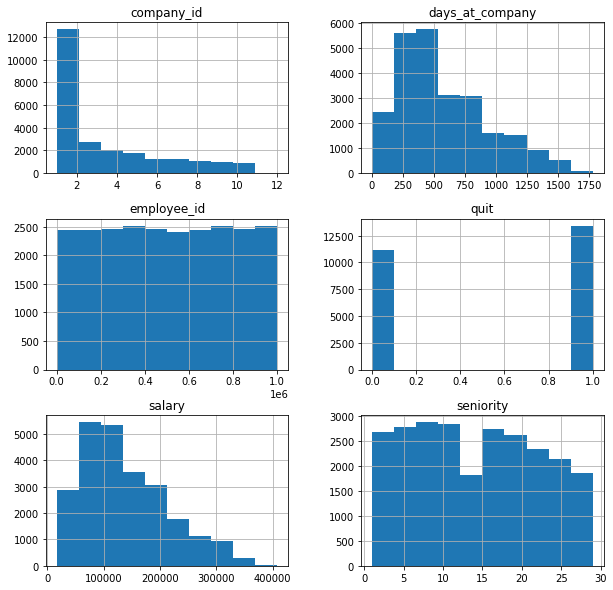

In [5]:
print(pd.DataFrame.describe(df))
df.hist(figsize=(10,10))
plt.show()

In [6]:
# the outputs show how each factor impacts the likelihood of the turnover rate.
print(len(df.quit))
print(df.groupby(df.quit).mean())
print(df.quit.value_counts()/len(df))

24619
        employee_id  company_id  seniority         salary  days_at_company
quit                                                                      
0     501079.237759    3.387688  14.123392  141192.259112       527.039224
1     502162.777016    3.460788  14.114471  135633.574007       612.633127
1    0.545392
0    0.454608
Name: quit, dtype: float64


company_id    1     2     3     4    5    6    7    8    9    10  11  12
quit                                                                    
0           3865  2016  1218   909  772  579  532  468  432  385   4  12
1           4595  2189  1522  1141  978  709  691  573  526  479  12  12


Text(0.5, 0, 'Company ID')

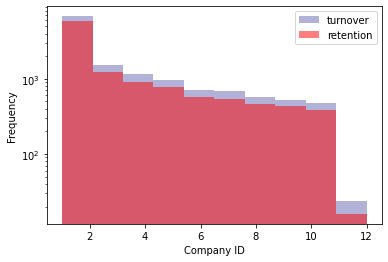

In [7]:
# turnover frequency by companies
print(pd.crosstab(df.quit, df.company_id)) 
df[df.quit==1].company_id.plot(kind='hist', logy=True, alpha=0.3, label= 'turnover', color = "navy")
df[df.quit==0].company_id.plot(kind='hist', logy=True, alpha=0.5, label= 'retention', color = "red")
plt.legend(loc=1, fontsize='medium')
plt.xlabel('Company ID')

dept  customer_service  data_science  design  engineer  marketing  sales
quit                                                                    
0                 4086          1508     602      2251       1384   1361
1                 5061          1664     773      2348       1778   1803


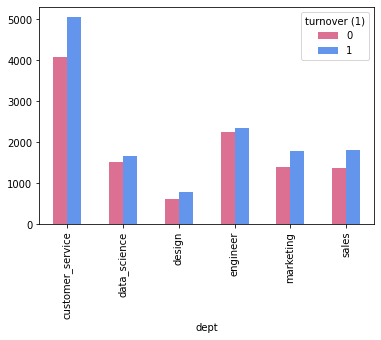

In [8]:
# turnover frequency by department. Customer Service dept has the most turnover
print(pd.crosstab(df.quit, df.dept)) 
pd.crosstab(df.dept,df.quit).plot(kind='bar', color=['palevioletred','cornflowerblue'])
plt.legend(title='turnover (1)')

days_at_company  3     4     5     6     10    11    12    13    18    19    \
quit                                                                          
0                   2     4     5    78     4     3    10    86    13     7   
1                   0     0     0     0     0     0     0     0     0     0   

days_at_company  ...  1707  1714  1721  1726  1728  1742  1763  1769  1770  \
quit             ...                                                         
0                ...     1     1     1     0     2     1     1     1     2   
1                ...     0     0     0     1     0     0     0     0     0   

days_at_company  1777  
quit                   
0                   3  
1                   0  

[2 rows x 1352 columns]


Text(0.5, 0, 'days')

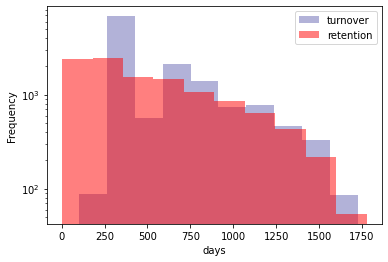

In [9]:
# turnover frequency by days at company. There is a peak (250-500 days) where turnover is highest. 
print(pd.crosstab(df.quit, df.days_at_company)) 
df[df.quit==1].days_at_company.plot(kind='hist', logy=True, alpha=0.3, label= 'turnover', color = "navy")
df[df.quit==0].days_at_company.plot(kind='hist', logy=True, alpha=0.5, label= 'retention', color = "red")
plt.legend(loc=1, fontsize='medium')
plt.xlabel('days')

seniority   1    2    3    4    5    6    7    8    9    10  ...   20   21  \
quit                                                         ...             
0          431  442  434  473  403  379  417  422  422  404  ...  375  327   
1          426  496  446  421  529  571  510  582  519  521  ...  467  452   

seniority   22   23   24   25   26   27   28   29  
quit                                               
0          359  355  345  312  335  300  265  318  
1          403  428  394  399  357  342  318  306  

[2 rows x 29 columns]


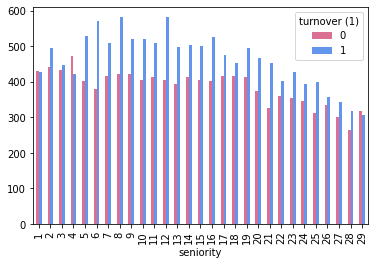

In [10]:
# turnover frequency by years of seniority
print(pd.crosstab(df.quit, df.seniority)) 
pd.crosstab(df.seniority,df.quit).plot(kind='bar', color=['palevioletred','cornflowerblue'])
plt.legend(title='turnover (1)')

Text(0.5, 0, 'Salary')

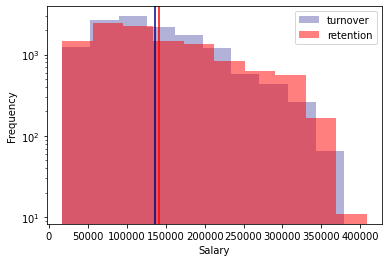

In [11]:
# turnover frequency by salary. 
df[df.quit==1].salary.plot(kind='hist', logy=True, alpha=0.3, label= 'turnover', color = "navy")
df[df.quit==0].salary.plot(kind='hist', logy=True, alpha=0.5, label= 'retention', color = "red")
plt.axvline(df[df.quit==1].salary.mean(), color = 'navy', label = '')
plt.axvline(df[df.quit==0].salary.mean(), color = 'red', label = '')
plt.legend(loc=1, fontsize='medium')
plt.xlabel('Salary')

## Take Away from the EDA:
Employees who turnovered, on average:

    (1) work in customer service deaprtment
    (2) left companies when they just around 1 year of tenure (250 - 500 days)
    (3) mid-senior level (5-15 years of seniority) 

Thus, I anticipate that department, seniority, days at company will be important feautures for prediction.

## Turnover Model: comparison three models to predict exmplyee churn: 
### logistic regression vs. random forest vs. support vector machine  

In [12]:
cat_vars=['company_id','dept']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    df1=df.join(cat_list)
    final=df1
#print(final)
final.dropna()
#final = df[['company_id','dept','seniority','salary','quit']]
#final = pd.get_dummies(data=final, columns=['company_id', 'dept'])
#print(final)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit,quit_date2,days_at_company,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
1,388804.0,8,design,21,191000.0,2011-05-17,2012-03-16,1,2012-03-16,304,0,0,1,0,0,0
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10,1,2015-04-10,1110,0,0,1,0,0,0
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30,1,2015-01-30,662,0,0,0,1,0,0
6,561043.0,3,customer_service,18,119000.0,2012-07-02,2014-03-28,1,2014-03-28,634,1,0,0,0,0,0
7,702479.0,7,data_science,7,140000.0,2011-12-27,2013-08-30,1,2013-08-30,612,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34693,759749.0,1,design,19,199000.0,2014-02-24,2015-03-06,1,2015-03-06,375,0,0,1,0,0,0
34695,414232.0,6,design,22,150000.0,2014-09-29,2015-10-30,1,2015-10-30,396,0,0,1,0,0,0
34697,998574.0,5,marketing,6,106000.0,2013-09-23,2015-07-31,1,2015-07-31,676,0,0,0,0,1,0
34698,90987.0,3,customer_service,2,24000.0,2011-06-06,2013-07-11,1,2013-07-11,766,1,0,0,0,0,0


In [13]:
final.drop(df.columns[[0,1,2,4,5,6,8]], axis=1, inplace=True)
final.columns.values
final_vars=final.columns.values.tolist()
y=['quit']
X=[i for i in final_vars if i not in y]
#print(final)

X=final[X]
y=final[y]

#### 1. Logistic Regression model

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
from sklearn.metrics import accuracy_score
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logreg.predict(X_test))))

Logistic regression accuracy: 0.639


In [22]:
#logit_model=sm.Logit(y_train,X_train)
#result=logit_model.fit()
#print(result.summary2())

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.38      0.48      3308
           1       0.63      0.85      0.72      4078

    accuracy                           0.64      7386
   macro avg       0.65      0.61      0.60      7386
weighted avg       0.65      0.64      0.62      7386



#### 2. Random Forest model

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

<ipython-input-18-2ae5f042fe42>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [19]:
print('Random Forest Accuracy: {:.3f}'.format(accuracy_score(y_test, rf.predict(X_test))))

Random Forest Accuracy: 0.732


In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.68      0.69      3308
           1       0.75      0.78      0.76      4078

    accuracy                           0.73      7386
   macro avg       0.73      0.73      0.73      7386
weighted avg       0.73      0.73      0.73      7386



#### 3. Support Vector model

In [28]:
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [29]:
print('Support vector machine accuracy: {:.3f}'.format(accuracy_score(y_test, svc.predict(X_test))))

Support vector machine accuracy: 0.688


In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.31      0.47      3308
           1       0.64      1.00      0.78      4078

    accuracy                           0.69      7386
   macro avg       0.81      0.65      0.62      7386
weighted avg       0.79      0.69      0.64      7386



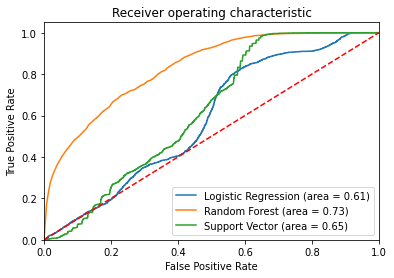

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

svc_roc_auc = roc_auc_score(y_test, svc.predict(X_test))
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_test, svc.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(svc_fpr, svc_tpr, label='Support Vector (area = %0.2f)' % svc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

#### Summary 

As shown above, random forest seems to be the best model among the three in that it predicts both classes equally well while logistic regression and support vector are overpredicting one class (e.g.,  recall and f-1 scores in the two models). Also, ROC curve shows that random forest, without having to overpredict false postivie, can predict true positive relativly well. (When true postivie rate is high and false postive rate (error) is low, the area of under curve is larger. Thus, the larger area of under roc curve is, the better a model performance because larger area indicates less error, and more correct responses).

Survival analysis can be consider as another possible model. It considers both events and time and estimates the impact of covariates on time in the survival data. It is often used for predicting such as death in biological organisms or failure in machines. Given that predicting employee churn  is also basically to analyze the expected duration of time before an event happen (e.g., turnover), it can be also applied for this case. 